# Tutorial: Linear Parametrization of $\texttt{JKOnet}^\ast$ in Euclidean space

In this tutorial, we will recover the potential within a simplified framework in Euclidean space by utilizing the Linear Parametrization of $\texttt{JKOnet}^\ast$. We will create a trajectory which will serve as training data, we will solve the linear system of equations to find the right coefficients and finally we will visualize the outcomes.

If the potential is parametrized linearly, i.e. $ V_{\theta}(x) = \theta^\top \phi(x) $, we can find a closed form solution for $\theta$. We start with an expression of the loss that we aim to minimize and that is explicit in $\theta$.

\begin{equation}
   L(\theta) = \sum_{t=0}^{T-1} \left\| \nabla \phi(x_{t+1})^\top \theta + \frac{1}{\tau}(x_{t+1}-x_t) \right\|^2.
\end{equation}

If we derivate and solve $\nabla{\theta}\mathcal{L}(\theta) = 0$, we get the optimum coefficients for $\theta$.

$$
\theta = -\frac{1}{\tau} \left( \sum_{t=0}^{T-1} \nabla \phi(x_{t+1}) \nabla \phi(x_{t+1})^\top \right)^{-1} \left( \sum_{t=0}^{T-1} \nabla \phi(x_{t+1})(x_{t+1}-x_t) \right).
$$

In [1]:
from jax import grad, vmap
import jax.numpy as jnp
from jax.scipy.linalg import inv
from jax.numpy import linalg
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Define the Real Potential Function and Its Gradient
We define the real potential function and compute its gradient with the autograd feature of JAX.

In [2]:
def V_real(x):
    return -x**2 + 30*x
grad_V_real = grad(V_real)

## Step 2: Define the Features
In this simple case it suffices with polynomial features. We define both $\phi$ and $\nabla\phi$.

In [3]:
def phi_x(x):
    return jnp.array([x, x**2])
def grad_phi_x(x):
    return jnp.array([1, 2*x])

## Step 3: Generate Training
We generate a trajectory according to the explicit scheme
$$
x_{t+1} = x_{t} - \tau \nabla V(x_{t}, t).
$$

In [4]:
#Generate the data points so that they follow the potential
x_value = 10.0
num_iterations = 101
x_array = jnp.zeros(num_iterations)
tau = 0.01

for i in range(num_iterations):
    x_array = x_array.at[i].set(x_value)
    x_value = x_value - tau * grad_V_real(x_value)

## Step 4: Solving the Linear System of Equations
We solve the linear system of equations.
$$
M = \left( \sum_{t=0}^{T-1} \nabla \phi(x_{t+1}) \nabla \phi(x_{t+1})^\top \right)
$$

$$
V= \left( \sum_{t=0}^{T-1} \nabla \phi(x_{t+1})(x_{t+1}-x_t) \right)
$$


$$
\theta = \frac{1}{\tau} \cdot \left( - \mathbf{M}^{-1} \cdot \mathbf{V} \right)
$$


In [5]:
#Non-vectorized approach
# M=0
# V=0
# for i in range(len(x_array)-1):
#     M += jnp.outer(grad_phi_x(x_array[i+1]),grad_phi_x(x_array[i+1]))
#     V += grad_phi_x(x_array[i+1]) * (x_array[i+1]-x_array[i])

#Vectorized approach
grad_phi_x_mapped = vmap(grad_phi_x)
x_diff = x_array[1:] - x_array[:-1]
M = jnp.sum(vmap(jnp.outer)(grad_phi_x_mapped(x_array[1:]), grad_phi_x_mapped(x_array[1:])), axis=0)
V = jnp.sum(grad_phi_x_mapped(x_array[1:]) * x_diff[:, jnp.newaxis], axis=0)

teta = 1/tau * jnp.dot(-inv(M),V)

## Step 5: Reconstruct Potential and Generate Predicted Trajectories
Once we have $\theta$ we can reconstruct the potential with the features. Finally, we generate the predicted trajectory.

In [6]:
def potential(x):
    phi_x_value = phi_x(x)
    return jnp.dot(phi_x_value, teta).squeeze()
grad_potential = grad(potential)

x_reconstructed = jnp.zeros(num_iterations)
t_values = jnp.linspace(0, 1, num_iterations)
x_value = 10.0
for i in range(num_iterations):
    x_reconstructed = x_reconstructed.at[i].set(x_value)
    x_value = x_value - tau * grad_potential(x_value)


## Step 6: Plotting the results
We plot the learned and real trajectories to visualize the performance of our model.

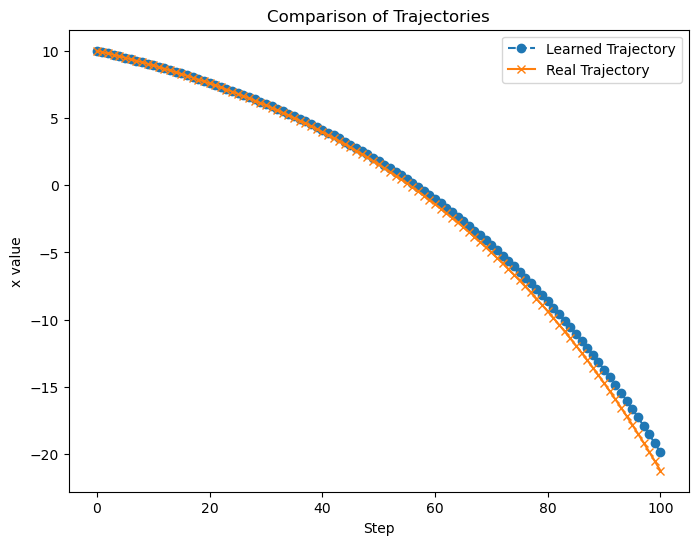

In [7]:
# Plotting the trajectories
plt.figure(figsize=(8, 6))

plt.plot(x_reconstructed, label='Learned Trajectory', linestyle='--', marker='o')
plt.plot(x_array, label='Real Trajectory',linestyle='-', marker='x')
plt.xlabel('Step')
plt.ylabel('x value')
plt.title('Comparison of Trajectories')
plt.legend()
plt.show()

# np.savetxt('Linear/traj_pred.txt', np.column_stack(
#             (t_values, x_reconstructed.T)), fmt='%-7.4f')
# 
# np.savetxt('Linear/traj_real.txt', np.column_stack(
#                 (t_values, x_array.T)), fmt='%-7.4f')